In [1]:
#!pip install pandas_profiling

# Libraries and Global Settings

In [58]:
import pandas as pd  # work with Pandas dataframes
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns # Visualizations 

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from keras import layers
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import RMSprop

import warnings # Funktionalität zur Unterdrückung von Warnungen
warnings.filterwarnings('ignore')

In [3]:
%%html
<style>
table {float:left}
</style>

# Importing Data

Fist of all we import the data which were generated in the whole preprocess (`df_for_ML`).

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [5]:
df_for_ML = pd.read_csv('df_for_ML.csv', parse_dates=['Datum'], date_parser=dateparse)

In [6]:
df_for_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7458 entries, 0 to 7457
Data columns (total 9 columns):
Datum           7458 non-null datetime64[ns]
Temp            7458 non-null float64
WG              7458 non-null float64
WR              7458 non-null float64
Druck           7458 non-null float64
NO              7458 non-null float64
NO2             7458 non-null float64
Niederschlag    7458 non-null float64
PM10            7458 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 524.5 KB


In [7]:
df_for_ML=df_for_ML.sort_values(by=['Datum'], axis=0, ascending=True)
df_for_ML

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10
0,2000-01-01,3.718,1.959896,234.922917,991.80,17.6266,24.236,3.5892,11.3772
1,2000-01-02,3.848,2.172912,222.511250,996.90,14.2886,28.698,3.5212,12.3972
2,2000-01-03,1.463,2.295208,220.181250,996.20,19.0638,35.336,0.8398,19.9480
3,2000-01-04,4.934,3.574979,220.885417,989.90,8.2660,24.210,1.4894,11.4780
4,2000-01-05,6.917,2.237208,220.554167,989.70,11.3496,26.208,4.3200,12.9260
...,...,...,...,...,...,...,...,...,...
7452,2020-05-27,17.300,1.700000,212.000000,1000.09,6.1000,21.700,0.0000,12.1060
7453,2020-05-28,17.300,2.400000,28.000000,996.45,4.2000,23.500,0.0000,13.9400
7454,2020-05-29,16.200,2.200000,129.000000,993.43,2.8000,18.700,0.0000,21.6300
7455,2020-05-30,15.900,2.400000,27.000000,989.46,2.4000,18.400,0.0000,13.1080


# Modeling

## Data Preparation

### Selection of Timeframe

We decided only to analyze and predict date where we have real particulates data and not derived with the KNN imputer.

In [8]:
startDate="2003-01-01"
endDate="2018-12-31"

In [9]:
df_for_ML=df_for_ML[(df_for_ML["Datum"] >= startDate) & (df_for_ML["Datum"] <= endDate)]

In [10]:
df_for_ML.tail()

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10
6935,2018-12-27,0.8,0.8,21.5,995.43,54.557,43.7,0.0,18.4
6936,2018-12-28,1.3,0.8,256.0,996.84,54.557,38.9,0.0,17.4
6937,2018-12-29,2.4,1.3,230.3,1000.46,11.600,28.0,0.1,11.5
6938,2018-12-30,6.5,2.1,244.0,1000.46,1.300,12.3,0.7,8.4
6939,2018-12-31,6.9,0.7,213.9,1001.15,7.600,21.6,0.9,9.3


### Split Data into Training and Validation Samples

We split the date with train data for periods 2003-2017 and test the models on data of 2017.

In [11]:
splitDate="2017-12-31"

In [12]:
df_train=df_for_ML[df_for_ML["Datum"] <= splitDate]
df_test=df_for_ML[df_for_ML["Datum"] > splitDate]

### Data Scaling and Normalization

Although we performed the outlier detection in the preprocessing we see that the rainfall has still many values outside the IQR. That is we are performing the `RobustScaler` from Sklearn which is robust to outliers.

In [13]:
df_train_woDate = df_train.drop('Datum', axis=1)
x = df_train_woDate.values #returns a numpy array
robustScaler = RobustScaler()
x_scaled = robustScaler.fit_transform(x)
df_train_norm = pd.DataFrame(x_scaled)

In [14]:
df_train_norm.describe()

,0,1,2,3,4,5,6,7
count,5480.000000,5480.000000,5480.000000,5480.000000,5.480000e+03,5480.000000,5480.000000,5480.000000
mean,-0.018177,0.210239,-0.206402,-0.062060,3.253736e-01,0.092030,1.058611,0.142565
std,0.640685,0.867229,0.726461,0.801074,8.133646e-01,0.758324,2.255737,0.762329
min,-1.993983,-1.555320,-2.395405,-2.025243,-5.638411e-01,-1.548357,-0.052224,-1.515063
25%,-0.524596,-0.386359,-0.703363,-0.526805,-2.928761e-01,-0.446050,-0.052224,-0.420549
50%,0.000000,0.000000,0.000000,0.000000,-4.391019e-17,0.000000,0.000000,0.000000
75%,0.475404,0.613641,0.296637,0.473195,7.071239e-01,0.553950,0.947776,0.579451
max,1.640608,3.081994,1.758384,1.937621,2.129774e+00,2.272198,9.967380,1.962203


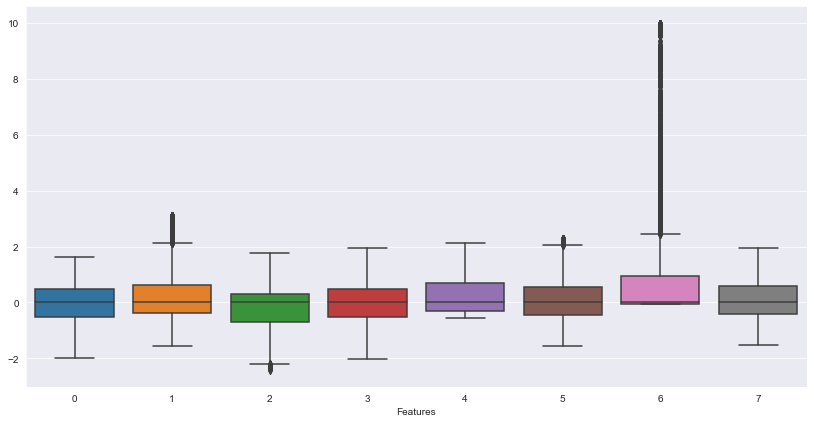

In [15]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_train_norm)
plt.xlabel("Features")
plt.show()

In [16]:
df_test_woDate = df_test.drop('Datum', axis=1)
x = df_test_woDate.values #returns a numpy array
robustScaler = RobustScaler()
x_scaled = robustScaler.fit_transform(x)
df_test_norm = pd.DataFrame(x_scaled)

In [17]:
df_test_norm.describe()

,0,1,2,3,4,5,6,7
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,-0.060211,0.305022,-0.632800,-0.060327,0.465016,0.031653,1.970959,0.184492
std,0.611236,1.162829,2.896107,0.929552,1.181778,0.679746,4.823674,0.818159
min,-1.653846,-1.400000,-8.240964,-2.319265,-0.578431,-1.515723,0.000000,-1.195876
25%,-0.538462,-0.400000,-0.373494,-0.492268,-0.313725,-0.477987,0.000000,-0.412371
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.461538,0.600000,0.626506,0.507732,0.686275,0.522013,1.000000,0.587629
max,1.146154,5.733208,5.843373,2.430735,4.760490,2.138365,23.000000,2.629969


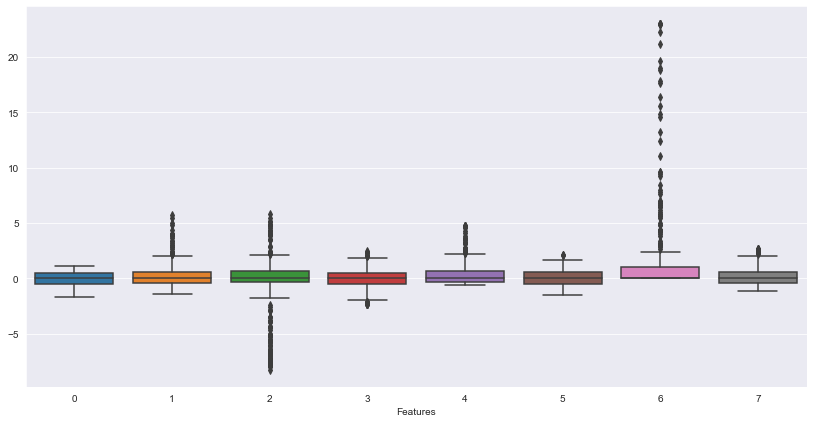

In [18]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_test_norm)
plt.xlabel("Features")
plt.show()

Now we want to return the column names.

In [19]:
i = 0
dictColumn = {}
for i in range(0,(len(df_test_woDate.columns))):
    dictColumn.update({list(df_test_norm.columns)[i]:list(df_test_woDate.columns)[i]})
    i=i+1
dictColumn

{0: 'Temp',
 1: 'WG',
 2: 'WR',
 3: 'Druck',
 4: 'NO',
 5: 'NO2',
 6: 'Niederschlag',
 7: 'PM10'}

In [20]:
df_train_norm=df_train_norm.rename(columns=dictColumn)
df_test_norm=df_test_norm.rename(columns=dictColumn)

In [21]:
df_train_norm.head()

,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10
0,-0.499301,0.537380,-0.888246,-0.978352,0.885808,-0.375204,0.505389,1.962203
1,-0.032202,2.749071,0.261684,-2.025243,-0.169688,-0.481939,9.967380,-1.079931
2,-0.287530,2.695324,0.282257,-1.924451,-0.079778,-0.371009,1.028151,-0.164626
3,-0.573535,-0.288877,-0.057264,-1.795437,0.500266,0.072710,9.967380,-0.641792
4,-1.146477,0.032476,-0.642685,-0.978352,0.249663,-0.288977,0.226582,-0.048469


### Split Data into Input and Target Data for Neural Networks

In [22]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        targets = y.iloc[i+time_steps]
        Xs.append(v)        
        ys.append(targets)
    return np.array(Xs), np.array(ys)

On basis of the last three weeks we want to predict the target value for particulate.

In [23]:
TIME_STEPS = 21
STEP = 1

X_train, y_train = create_dataset(
    #df_train.drop(columns=['PM10']), 
    df_train_norm,
    df_train_norm.PM10, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    #df_test.drop(columns=['PM10']),
    df_test_norm,
    df_test_norm.PM10, 
    TIME_STEPS, 
    STEP
)

### Split Data into Input and Target Data for Baseline Model

In [24]:
TIME_STEPS = 1
STEP = 1

X_train_base, y_train_base = create_dataset(
    #df_train.drop(columns=['PM10']), 
    df_train_norm,
    df_train_norm.PM10, 
    TIME_STEPS, 
    STEP
)

X_test_base, y_test_base = create_dataset(
    #df_test.drop(columns=['PM10']),
    df_test_norm,
    df_test_norm.PM10, 
    TIME_STEPS, 
    STEP
)

## Alogrithms Selection

## Baseline Models

At this point we have to reshape the given features numpay arrey in a compatible shape for the baseline model `linear regression`.

In [32]:
X_train_base = X_train_base.reshape(-1,8) 
X_test_base = X_test_base.reshape(-1,8)

In [35]:
#X_train_base.shape 
#y_train_base.shape
#X_test_base.shape
#y_test_base.shape

Print the second datarow to compare the value of particulate with the first data row in the `y_train` data set!

In [41]:
X_train_base[1]

array([-0.03220203,  2.7490706 ,  0.26168437, -2.02524274, -0.16968798,
       -0.48193894,  9.96737966, -1.07993148])

First data row in the `y_train` data set.

In [40]:
y_train_base[0]

-1.0799314753687381

In [44]:
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train_base, y_train_base)

LinearRegression()

In [45]:
test_pred = regr.predict(X_test_base)

In [48]:
y_test_base[0:10]

array([-0.81443299, -0.64948454, -0.40206186, -0.55670103,  0.        ,
        0.60824742,  0.95876289,  1.40206186,  0.94845361,  1.37113402])

In [47]:
test_pred[0:10]

array([ 0.60027032, -0.63124033, -0.98447538, -0.84957948, -0.49257006,
       -0.04068703,  1.13264801,  1.38016969,  0.55079705,  0.27268831])

In [61]:
print("Coeffs: ", regr.coef_)

print("Intercept: ", regr.intercept_)

print("R2: ", regr.score(X_test_base, y_test_base))

print("MSE: ", mean_squared_error(y_test_base, test_pred))

Coeffs:  [-0.0940739  -0.03383687 -0.11222679  0.07813494 -0.07828026  0.08210639
 -0.01146359  0.5800778 ]
Intercept:  0.07655889952721832
R2:  0.3710221609462565
MSE:  0.4176661576376381


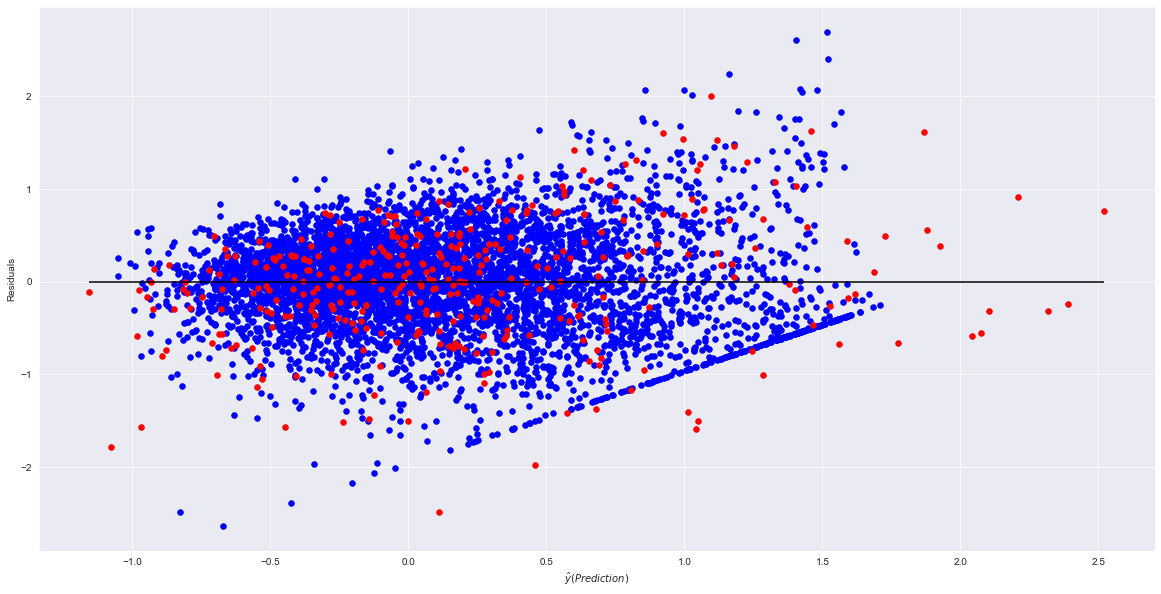

In [63]:
# Residual Plot (Restwert)
train_pred = regr.predict(X_train_base)
test_pred = regr.predict(X_test_base)

min_val = min(min(train_pred), min(test_pred))
max_val = max(max(train_pred), max(test_pred))


plt.figure(figsize=(20,10))
plt.scatter(train_pred, train_pred - y_train_base, color="blue", s=30)
plt.scatter(test_pred, test_pred - y_test_base, color="red", s=30)
plt.hlines(y = 0, xmin =min_val, xmax=max_val)
plt.xlabel("$\hat{y} (Prediction)$")
plt.ylabel("Residuals")
plt.show()

## Deep Learning Models

In [24]:
model = Sequential()
model.add(layers.LSTM(units=200, 
                      return_sequences= True,
                      activation ='tanh', 
                      input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(layers.Flatten())
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 21, 200)           167200    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4201      
Total params: 171,401
Trainable params: 171,401
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='RMSprop', loss='mse',metrics=["accuracy"])
history = model.fit(x=X_train, y=y_train, epochs=15, validation_data=(X_test, y_test))

Train on 5459 samples, validate on 344 samples
Epoch 1/15
5459/5459 [==============================] - 4s 788us/step - loss: 0.3807 - accuracy: 3.6637e-04 - val_loss: 0.5593 - val_accuracy: 0.0000e+00
Epoch 2/15
5459/5459 [==============================] - 5s 857us/step - loss: 0.2916 - accuracy: 3.6637e-04 - val_loss: 0.5062 - val_accuracy: 0.0029
Epoch 3/15
5459/5459 [==============================] - 5s 843us/step - loss: 0.2792 - accuracy: 3.6637e-04 - val_loss: 0.5100 - val_accuracy: 0.0000e+00
Epoch 4/15
5459/5459 [==============================] - 5s 879us/step - loss: 0.2682 - accuracy: 3.6637e-04 - val_loss: 0.4132 - val_accuracy: 0.0029
Epoch 5/15
5459/5459 [==============================] - 5s 832us/step - loss: 0.2654 - accuracy: 3.6637e-04 - val_loss: 0.4611 - val_accuracy: 0.0029
Epoch 6/15
5459/5459 [==============================] - 5s 857us/step - loss: 0.2614 - accuracy: 3.6637e-04 - val_loss: 0.4624 - val_accuracy: 0.0029
Epoch 7/15
5459/5459 [=======================

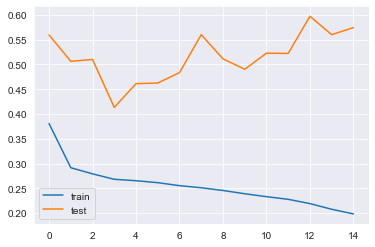

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Hyperparamters Optimization

## Evaluation

### Model Evaluation (Performance)

#### Training Phase

#### Testing Phase

# Projekt Evaluation

# Deployment

In the first phase of CRISP the overall business-case, which shall be supported by the data mining process must be clearly defined and understood. Then the goal of the data mining project itself must be defined. This includes the specification of metrics for measuring the performance of the data mining project.

In the second phase data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

In the third phase data must be investigated and understood more thoroughly. Common means for understanding data are e.g. visualization and the calculation of simple statistics. Outliers must be detected and processed, sampling rates must be determined, features must be selected and eventually be transformed to other formats.

In the modelling phase various algorithms and their hyperparameters are selected and applied. Their performance on the given data is determined in the evaluation phase.

The output of the evaluation is usually fed back to the first phases (business- and data-understanding). Applying this feedback the techniques in the overall process are adapted and optimized. Usually only after several iterations of this process the evaluation yields good results and the project can be deployed.